In [1]:
import vmodel
import os
import numpy as np
import h5py
import datetime
import scipy.spatial
import math


def calc_order(vel: np.ndarray) -> float:
    """Compute order parameter from velocity matrix
    Args:
        vel: velocity matrix (N x D)
    Returns:
        order: velocity correlation
    """
    N, _ = vel.shape
    speed = np.linalg.norm(vel, axis=1, keepdims=True)  # N x 1
    speed_prod = speed.dot(speed.T)  # N x N
    mask = (speed_prod != 0)  # avoid division by zero!
    dot_prod = vel.dot(vel.T)  # N x N
    np.fill_diagonal(dot_prod, 0)  # i != j
    return (dot_prod[mask] / speed_prod[mask]).sum() / (N * (N - 1))

    


out_str = "/extra2/knopf/vmodel_output/noPred_/"
saveLoc = "/extra2/knopf/vmodel_output/"
saveName = "noPred_"


args = {
'nprey': 100,
'npred': 1,
'frange': 10,
'fstr': 0.0,
'visPred': 300.0,
'visPrey': 330,
'astr': 3.0,
'dphi': 0.2,
'repPrey': 3,
'repRadPrey': 1.5,
'repPred': 1,
'repRadPred': 20,
'attPrey': 3,
'attRadPrey': 1.5,
'repCol': 10000000,
'hstr': 1,
'steps': 1500,
    }



paraChange1_name = "astr"
paraChange2_name = "dphi"
steps = 1
reps = 1

total = steps*steps*reps

paraChange1_val = np.linspace(0,3,steps)
paraChange2_val = np.linspace(0,1,steps)

pol_scan = np.zeros((steps, steps))
IID_scan = np.zeros((steps, steps))
CND_scan = np.zeros((steps, steps))

time_now = datetime.datetime.now()
time_elapsed = 0


for i in range(len(paraChange1_val)):
    
    for j in range(len(paraChange2_val)):

        #np.savetxt(str(saveLoc)+""+str(saveName)+"pol_"+str(paraChange1_name)+"_"+str(paraChange2_name)+".csv", pol_scan, delimiter=",")
  
        pol_reps = []
        IID_reps = []
        CND_reps = []
        
        args[paraChange1_name] = paraChange1_val[i]
        args[paraChange2_name] = paraChange2_val[j]

        npred = args["npred"]
        nprey = args["nprey"]

        args_str = '_'.join(f'{k}_{v}' for k, v in args.items())

        #file_h5 = f'{out_str}_{args_str}.states.nc'
        #file_h5 = f'/home/lars/vmodel_output/_nprey_100_npred_1_frange_10_fstr_0.0_visPred_90.0_visPrey_330_astr_3_dphi_0.2_repPrey_3_repRadPrey_1_repPred_1_repRadPred_20_attPrey_3_attRadPrey_1_repCol_10000000_hstr_1_steps_50000.states.nc'
        file_h5 = f'/home/lars/vmodel_output/_nprey_100_npred_1_frange_10_fstr_0.0_visPred_300.0_visPrey_330_astr_1.7368421052631577_dphi_0.15789473684210525_repPrey_3_repRadPrey_1.5_repPred_1_repRadPred_20_attPrey_3_attRadPrey_1.5_repCol_10000000_hstr_1_steps_1500.states.nc'
        
        #file_h5 = f'/home/lars/vmodel_output/_nprey_100_npred_1_frange_10_fstr_0.0_visPred_300.0_visPrey_330_astr_2.6842105263157894_dphi_0.15789473684210525_repPrey_3_repRadPrey_1.5_repPred_1_repRadPred_20_attPrey_3_attRadPrey_1.5_repCol_10000000_hstr_1_steps_1500.states.nc' 

        #print(file_h5)
        


        try:
            with h5py.File(file_h5) as fh5:
                vel = np.moveaxis(np.array(fh5['/velocity']), [3,2], [1,3])[:,:,:,:]
                pos = np.moveaxis(np.array(fh5['/position']), [3,2], [1,3])[:,:,:,:]

        except:
            print("File not Found, going on")
        
        

        for rep in range(reps):
            rep = 0
            
            vel_rep = vel[rep,:,:,:]
            pos_rep = pos[rep,:,:,:]


            #print(np.shape(vel_rep))


            pol = []
            IID = []
            CND = []
            predTime = 2
            for ii in range(1300,args["steps"]-predTime):
                pol.append(calc_order(vel_rep[ii,:nprey,:]))
                pos_calc = pos_rep[ii,:nprey,:]
                dist = scipy.spatial.distance.cdist(pos_calc,pos_calc)
                IID.append(dist.sum() / (nprey * (nprey - 1)))
                dist[dist==0]=100
                CND.append(np.mean(dist.min(axis=1)))
                
                
                
            pol_reps.append(np.mean(pol))
            IID_reps.append(np.mean(IID))
            CND_reps.append(np.mean(CND))
            
            
        time_last = time_now
            
        time_now = datetime.datetime.now()
            
        time_diff = np.round((time_now-time_last).total_seconds(),2)
            
        time_elapsed += time_diff

        progress = rep+reps*(j+i*steps)
            
        time_finish = (time_elapsed/progress) * (total - progress)
            
        print("progress: "+str(np.round(100*progress/total,2))+" %, time running: "+str(np.round(time_elapsed,2))+" s, est. finish: "+str(np.round(time_finish/60,2))+" min.")
            
            
        pol_scan[i,j] = np.mean(pol_reps)
        IID_scan[i,j] = np.mean(IID_reps)
        CND_scan[i,j] = np.mean(CND_reps)



progress: 0.0 %, time running: 0.99 s, est. finish: inf min.


/tmp/ipykernel_49779/4128554537.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  time_finish = (time_elapsed/progress) * (total - progress)


In [12]:
np.shape(pos)

(30, 1498, 101, 2)

In [2]:
def get_angle(x1,y1,x2,y2):
    myradians = math.atan2(y1-y2, x1-x2)
    mydegrees = math.degrees(myradians)
    return mydegrees

import matplotlib.pyplot as plt

In [173]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [3]:
class Vect:

   def __init__(self, a, b):
        self.a = a
        self.b = b

   def findClockwiseAngle(self, other):
       # using cross-product formula
       return -math.degrees(math.asin((self.a * other.b - self.b * other.a)/(self.length()*other.length())))
       # the dot-product formula, left here just for comparison (does not return angles in the desired range)
       # return math.degrees(math.acos((self.a * other.a + self.b * other.b)/(self.length()*other.length())))

   def length(self):
       return math.sqrt(self.a**2 + self.b**2)

In [123]:
get_angle(0,-1,1,0)

-135.0

In [170]:
vector1 = Vect(0,1)
vector2 = Vect(1,0)
vector1.findClockwiseAngle(vector2)

90.0

In [165]:
angle_between((0,-1),(1,0))

1.5707963267948966

In [4]:
rep = 0
vel_rep = vel[rep,:,:nprey,:]
pos_rep = pos[rep,:,:nprey,:]

time, N, dim = np.shape(pos_rep)
com_pos = np.zeros((time,2))
angle_time = []
angle_time_full = np.zeros((time, N, 2))

for i in range(time):
    com_pos[i] = np.mean(pos_rep[i,:,0]),np.mean(pos_rep[i,:,1])
    dir_com = com_pos[i] - pos_rep[i,:,:]
    
    angle = 0
    for j in range(nprey):
        vector2 = Vect(dir_com[j,0],dir_com[j,1])
        vector1 = Vect(vel_rep[i,j,0],vel_rep[i,j,1])
        angle_i = vector1.findClockwiseAngle(vector2)
        
        angle += angle_i
        angle_time_full[i, j, :] = angle_i
        
    angle_time.append(angle/nprey)

/tmp/ipykernel_10846/3244071200.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return -math.degrees(math.asin((self.a * other.b - self.b * other.a)/(self.length()*other.length())))


In [185]:
angle_time_mill = np.copy(angle_time)
af_mill = np.copy(angle_time_full)

In [23]:
vec1 = Vect(-0.22825414545146633,4.411833004127907)
vec2 = Vect(0.9986643325913226,0.041667695999804114)












try:
    vec1.findClockwiseAngle(vec2)
except:
    print("ERR")

In [17]:
vec1.findClockwiseAngle(vec2)

89.94278407881495

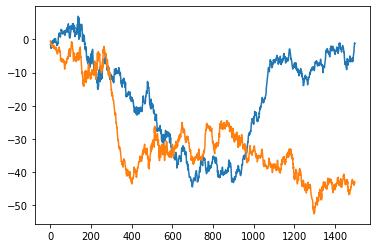

In [186]:
plt.plot(angle_time_swarm)
plt.plot(angle_time_mill)

In [193]:
af_swarm[800,:,0]

array([-6.33483047e+01, -5.39578499e+01, -8.39875474e+01, -5.04219396e+01,
       -7.95190675e+01,  4.73668624e+01, -6.47022516e+01, -8.23853090e+01,
       -4.16408073e+01, -6.29238626e+01, -7.27262985e+01, -6.09700904e-02,
       -1.78848135e+00, -6.99507336e+01, -4.94027650e+01, -5.29886915e+01,
       -8.25019642e+01,  9.46543772e+00, -5.41897346e+01, -8.46930784e+01,
       -7.41064598e+01,  1.64593870e+01, -6.75857375e+01, -1.52050934e+00,
       -3.85188094e+01, -5.36513886e+01, -5.18505577e+00,  4.28368077e+01,
       -1.39706176e+01, -6.31994399e+01, -3.23523374e+01, -8.61463970e+01,
        4.80657109e+01, -8.81853516e+01,  4.79386458e+01, -5.63911268e+00,
       -4.98243042e+01,  4.14832742e+01,  7.04454964e+01, -7.13397365e+01,
       -6.91496029e+01, -1.15828792e+01, -5.83161328e+01, -2.61346992e+01,
       -6.25941256e+01,  2.94539992e+01, -8.97007965e+01,  8.67920611e+01,
       -6.31748065e+01, -7.51998089e+01,  5.53172806e+01,  3.54552345e+01,
        5.76743886e+01, -

In [191]:
af_mill[1400,:,0]

array([ 7.79653084e+01, -5.59949086e+01, -1.55934593e+01, -5.54839735e+01,
       -5.39546617e+01, -8.98511248e+01, -8.02153121e+01, -3.67357726e+01,
        7.21054357e+00, -6.02402830e+01, -1.08731999e+01,  2.35514328e+01,
       -8.01334411e+01, -1.24120818e+01,  1.08984848e+01, -6.74395215e+01,
       -4.73346841e+01, -4.76471297e+01, -5.07554978e+01,  5.08850495e+01,
        8.60774703e+01, -3.39316364e+01, -4.56102988e+01, -2.60012610e+01,
       -4.19115680e+01, -2.64512252e+01, -5.39669433e+01, -8.65370730e+01,
       -8.22546866e+01, -1.44492123e+01, -8.82959402e+01, -5.24559790e+01,
       -8.21604320e+01,  4.29332196e+01, -6.45395095e+01, -8.79248094e+01,
       -3.87219020e+01, -8.28315956e+01, -5.46698763e+01, -7.13381716e+01,
       -7.32508844e+01, -4.92266385e+01, -6.86203870e+01, -7.63070050e+01,
       -3.08741628e+01, -7.57261163e+01, -7.23004809e+01,  5.07942278e+00,
       -2.19291075e+01, -7.77224313e+01, -6.64672937e+01, -6.92665673e+01,
        2.66602159e+00, -

In [32]:
test = np.zeros((10, 10, 10, 10))
np.save("test.csv", test)

In [118]:
paraChange1_val

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])

In [2]:
import matplotlib.pyplot as plt
import numpy as np

mill = np.load("/home/lars/vmodel_output/longsim_data/longsim_preyvis240v2_dphi_astr_vor_mill_astr_dphi.npy")
pol =  np.load("/home/lars/vmodel_output/longsim_data/longsim_preyvis240v2_dphi_astr_vor_pol_astr_dphi.npy")

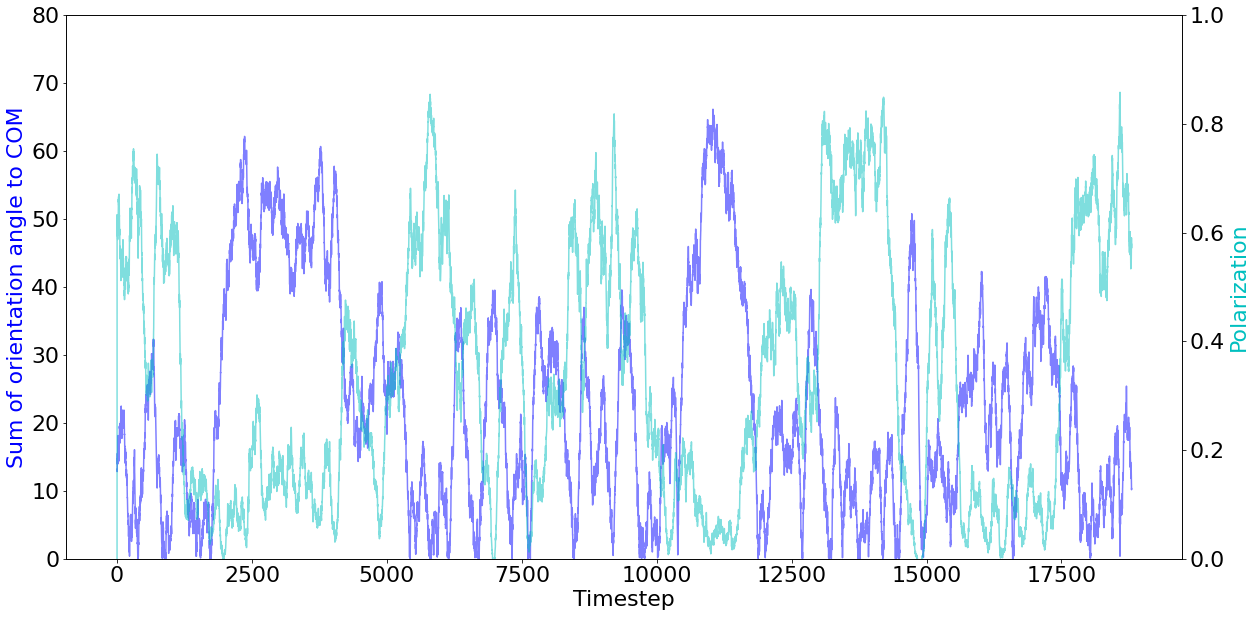

In [7]:
fig, ax1 = plt.subplots(1,1, figsize=(20,10))

rep = 1
astr = 9
dphi = 3

steps, steps, reps, time = np.shape(mill)
x = range(time)

ax2 = ax1.twinx()
ax1.plot(x, abs(mill[astr,dphi,rep,:]), 'b-', alpha = 0.5)
ax2.plot(x, pol[astr,dphi,rep,:], 'c-', alpha=0.5)

ax1.set_xlabel('Timestep')
ax1.set_ylim(0,80)
ax2.set_ylim(0,1)
ax1.set_ylabel('Sum of orientation angle to COM', color='b')
ax2.set_ylabel('Polarization', color='c')

plt.rcParams.update({'font.size': 22})

plt.show()

/tmp/ipykernel_119340/4072199799.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


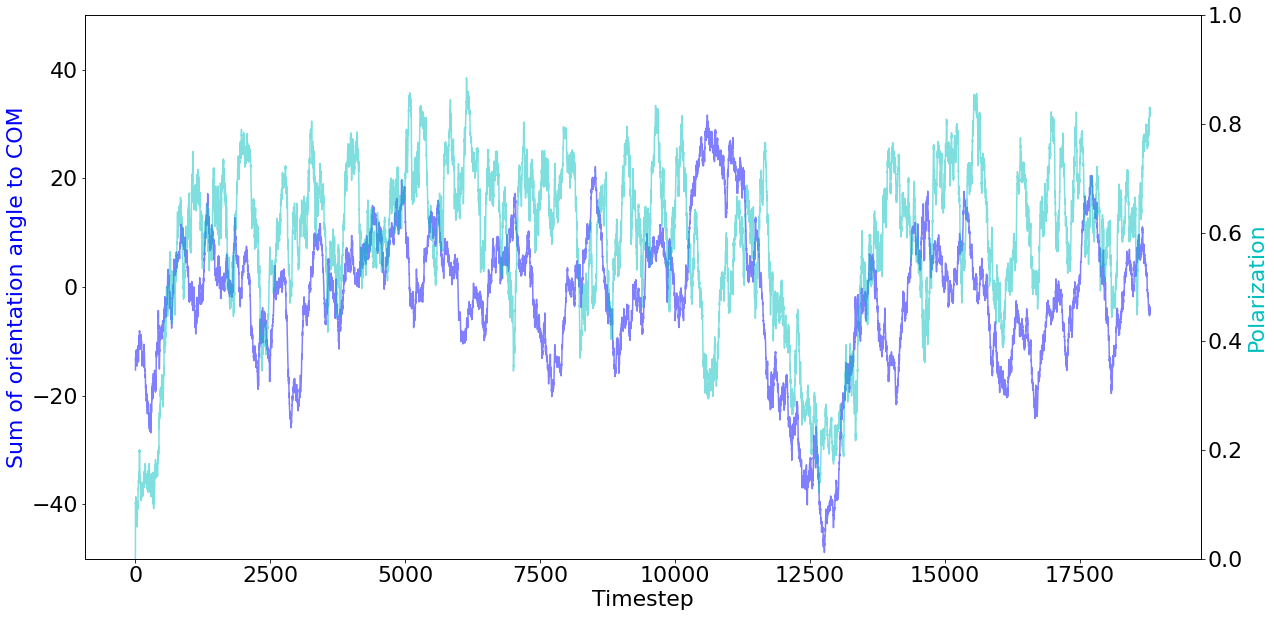

In [10]:
fig, ax1 = plt.subplots(1,1, figsize=(20,10))

rep = 5

astr = 5
dphi = 1

steps, steps, reps, time = np.shape(mill)
x = range(time)

ax2 = ax1.twinx()
ax1.plot(x, mill[astr,dphi,rep,:], 'b-', alpha = 0.5)
ax2.plot(x, pol[astr,dphi,rep,:], 'c-', alpha=0.5)

ax1.set_xlabel('Timestep')
ax1.set_ylim(-50,50)
ax2.set_ylim(0,1)
ax1.set_ylabel('Sum of orientation angle to COM', color='b')
ax2.set_ylabel('Polarization', color='c')

plt.rcParams.update({'font.size': 22})

plt.show()

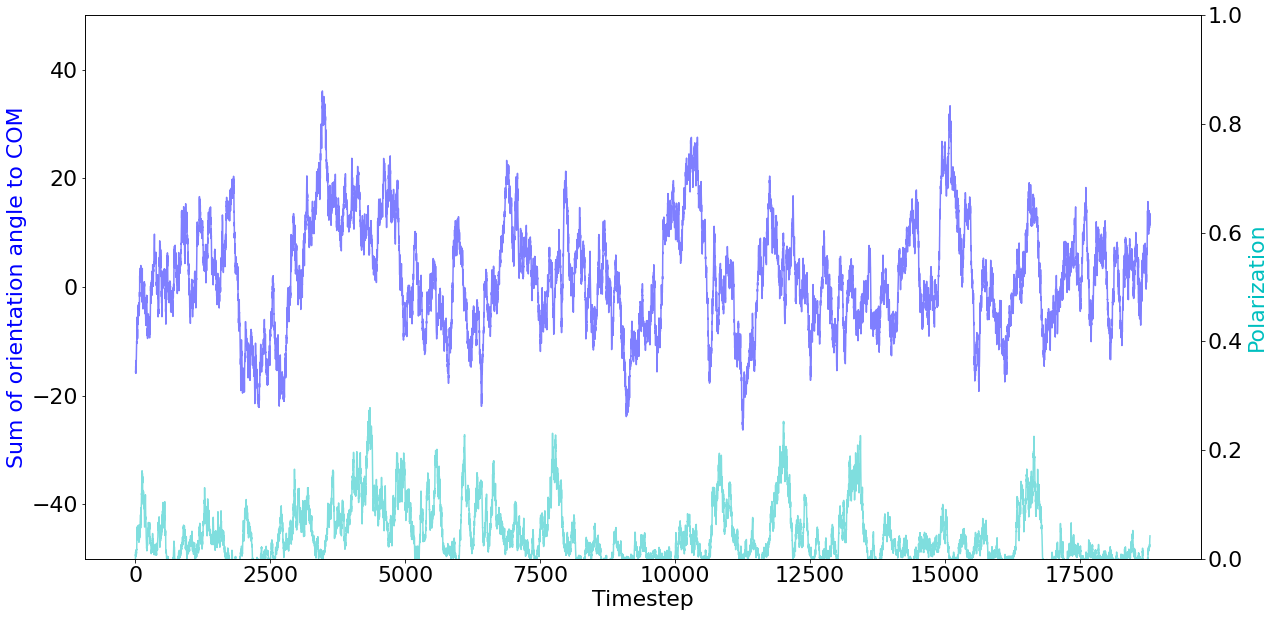

In [135]:
fig, ax1 = plt.subplots(1,1, figsize=(20,10))

rep = 3

astr = 3
dphi = 2

steps, steps, reps, time = np.shape(mill)
x = range(time)

ax2 = ax1.twinx()
ax1.plot(x, mill[astr,dphi,rep,:], 'b-', alpha = 0.5)
ax2.plot(x, pol[astr,dphi,rep,:], 'c-', alpha=0.5)

ax1.set_xlabel('Timestep')
ax1.set_ylim(-50,50)
ax2.set_ylim(0,1)
ax1.set_ylabel('Sum of orientation angle to COM', color='b')
ax2.set_ylabel('Polarization', color='c')

plt.rcParams.update({'font.size': 22})

plt.show()

In [93]:
np.shape(mill)

(10, 10, 20, 18800)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


mill = np.load("/home/lars/vmodel_output/test_mill_longsim_mill_astr_dphi.npy")
pol = np.load("/home/lars/vmodel_output/test_mill_longsim_pol_astr_dphi.npy")

paraChange1_name = "astr"
paraChange2_name = "dphi"
steps = 10
reps = 20

matplotlib.use("Agg")

paraChange1_val = np.linspace(0,3,steps)
paraChange2_val = np.linspace(0,1,steps)

for i in range(len(paraChange1_val)):
    
    for j in range(len(paraChange2_val)):

        


        
        for rep in range(reps):
            
            #fig.clf()
            fig, ax1 = plt.subplots(1,1, figsize=(20,10))
            steps, steps, reps, time = np.shape(mill)
            x = range(time)

            ax2 = ax1.twinx()
            
            ax1.plot(x, mill[i,j,rep,:], 'b-', alpha = 0.3)
            ax2.plot(x, pol[i,j,rep,:], 'c-', alpha=0.3)

            ax1.set_xlabel('Timestep')
            ax1.set_ylim(-50,50)
            ax2.set_ylim(0,1)
            ax1.set_ylabel('Sum of orientation angle to COM', color='b')
            ax2.set_ylabel('Polarization', color='c')

            plt.rcParams.update({'font.size': 22})

            #plt.show()
            plt.savefig("mill-pol_"+str(paraChange1_name)+"="+str(paraChange1_val[i])+"_"+str(paraChange2_name)+"="+str(paraChange2_val[j])+"_rep="+str(rep)+".png", facecolor="w")
            plt.close(fig)
            plt.clf()
            fig.clf()

<Figure size 432x288 with 0 Axes>

In [15]:
5*60+12

312

In [18]:
(312*12500/18000)/60

3.611111111111111